# Quantum Harmonic Oscillator

In this notebook we'll solve the quantum harmonic oscillator with machine learning techniques.

The Hamiltonian of the oscillator is:

$$ H = \frac{1}{2m}p^2 + \frac{m \omega^2}{2}x^2 $$

According to the variational principle of quantum mechanics, for any wave function $|\psi>$, 

$$ < \psi | H | \psi > ~ \ge ~ E_0 $$

When substitued into the variational principle, we have:

$$ \int_{-\infty}^{\infty} \psi^*(x) H \psi(x) dx $$
$$ \int_{-\infty}^{\infty} \psi^*(x) [\frac{1}{2m}p^2 + \frac{m \omega^2}{2}x^2 ] \psi(x) dx$$

Subsituting $p = -i \hbar \frac{\partial}{\partial x}$ :
$$ \int_{-\infty}^{\infty} \psi^*(x) \frac{1}{2m}[- \hbar]^2 \frac{\partial^2}{\partial x ^2}   \psi dx + \int_{-\infty}^{\infty} \psi^* \frac{m \omega^2}{2}x^2  \psi(x) dx$$

$$ \frac{-\hbar^2}{2m} \int_{-\infty}^{\infty} \psi^*(x)  \frac{\partial^2}{\partial x ^2}   \psi dx + \frac{m \omega^2}{2} \int_{-\infty}^{\infty} \psi^* x^2  \psi(x) dx $$

To solve this numerically, let's integrate by parts to turn a second derivative into two first derivatives:
$$ < \psi | H | \psi > = \frac{m \omega^2}{2} \int_{-\infty}^{\infty} \psi^* x^2  \psi(x) dx - \frac{\hbar^2}{2m} \left[\psi^*(x)\frac{\partial \psi (x)}{\partial x}  \Biggr|_{-\infty}^{\infty}  - \int_{-\infty}^{\infty} \frac{\partial \psi^*(x)}{\partial x} \frac{\partial \psi(x)}{\partial x} dx \right] $$

The wavefunctions for the harmonic oscillator have to got to zero at $\pm \infty$, so the first term in the integration by parts can be dropped.  Then, the total integral to evaluate is:

$$ < \psi | H | \psi > = \frac{m \omega^2}{2} \int_{-\infty}^{\infty} \psi^* x^2  \psi(x) dx + \frac{\hbar^2}{2m}  \int_{-\infty}^{\infty} \frac{\partial \psi^*(x)}{\partial x} \frac{\partial \psi(x)}{\partial x} dx $$

We have assumed above that the wave functions are normalized, but with ou approximation scheme we won't have normalized wavefunctions.  In this case, let's add in the normalization ourselves:

$$ < \psi | H | \psi > = \frac{1}{N} \left[\frac{m \omega^2}{2} \int_{-\infty}^{\infty} \psi^* x^2  \psi(x) dx + \frac{\hbar^2}{2m}  \int_{-\infty}^{\infty} \frac{\partial \psi^*(x)}{\partial x} \frac{\partial \psi(x)}{\partial x} dx \right]$$
where 
$$ N = \int_{-\infty}^{\infty} \psi^*(x) \psi(x) dx $$

To solve this, and estimate the ground state energy of the system, we need to find a wave function and estimate these two integrals.

We will use a pytorch module to approximate our wavefunction, which we can then differentiate.  The requirements of this system are that:
- the wavefunction must be normalizable
- the wavefunction must go to zero at $\pm \infty$

In [1]:
import numpy
import torch
from matplotlib import pyplot as plt

These are physical constants in this problem, which we'll set to 1 for ease:

In [2]:
omega = 1.0
hbar  = 1.0
M     = 1

# This is a granularity parameter:
delta = 0.0005

There are 3 available wavefunctions here:
- A module based on Hermite Polynomials, up to degree 3, that is exact up to normalization.
- A polynomial module that can be fit to any polynomial up to degree 3.
- A neural network that has no polynomial terms.

All components have the same submodule to handle the boundary conditions, which is an gaussian-like exponential that decays to zero at large $|x|$.

In [3]:
class ExponentialBoundaryCondition(torch.nn.Module):
    
    def __init__(self, exp=1.0, trainable=True):
        torch.nn.Module.__init__(self)

        # This is the parameter controlling the shape of the exponent:
        self.exponent = torch.nn.Parameter(torch.tensor(exp), requires_grad=trainable)


    def forward(self, inputs):
        
        return torch.exp(- (self.exponent * inputs) **2 / 2.)
        
        

In [4]:
class CorrectWavefunction(torch.nn.Module):


    def __init__(self, n):
        torch.nn.Module.__init__(self)
            
        # N is the degree of the polynomial:
        self.n = n
    
        self.alpha = M * omega / hbar
        self.norm  = numpy.power(self.alpha / numpy.pi, 0.25)
        
        if self.n == 0:
            pass
        elif self.n == 1:
            self.norm *= numpy.sqrt(2.)
        elif self.n == 2:
            self.norm *= numpy.sqrt(0.5)
        else:
            raise Exception("Unsupported degree of ", n)
    
        self.exp = ExponentialBoundaryCondition(exp=numpy.sqrt(self.alpha), trainable=False)
    
    def forward(self, inputs):
    
        y = inputs
        
        boundary_condition = self.exp(y)
        
        if self.n == 0:
            polynomial = 1
        elif self.n == 1:
            polynomial = y
        elif self.n == 2:
            polynomial = 2 * y**2 - 1
            
        return self.norm * boundary_condition * polynomial


In [5]:
class PolynomialWavefunction(torch.nn.Module):
    
    def __init__(self):
        torch.nn.Module.__init__(self)
        
#         self.layer1 = torch.nn.Linear(1,64)
#         self.layer2 = torch.nn.Linear(64, 1)
    
        self.const  = torch.nn.Parameter(torch.tensor(0.3), requires_grad=True)
        self.linear = torch.nn.Parameter(torch.tensor(0.2), requires_grad=True)
        self.quad   = torch.nn.Parameter(torch.tensor(0.2), requires_grad=True)

        self.norm   = torch.Tensor([1.0])
    
        self.exp = ExponentialBoundaryCondition()



    def forward(self, inputs):
        x = inputs

        boundary_condition = self.exp(x)


        poly = self.const + self.linear * x + self.quad * x**2

        # Multiply by a factor to enforce normalization and boundary conditions:
        # Note the exponent is within the power of 2 to make it's sign irrelevant
        x = self.norm *  poly * boundary_condition
        return x
    
    def update_normalization(self, inputs):
        # Inputs is expected to be a range of parameters along an x axis.
        with torch.no_grad():
            value = self.forward(inputs)
            N = value ** 2

            delta = inputs[1]-inputs[0]

            N = torch.sum(N) * delta
            self.norm *= 1/torch.sqrt(N)

            # The normalization condition is that the integral of the wavefunction squared
            # should be equal to 1 (probability sums to 1.)

        return
    
    def analytic_derivative(self, inputs):
        
        poly = self.const + self.linear * x + self.quad * x**2
        poly_prime = self.linear + 2 * self.quad * inputs
        exp = self.exp(x)
        
        res = exp * (-inputs) *poly + poly_prime * exp
        
        return self.norm * res
    
    def zero_grad(self):
        """Sets gradients of all model parameters to zero."""
        for p in self.parameters():
            if p.grad is not None:
                p.grad.data.zero_()

In [6]:
class NeuralWavefunction(torch.nn.Module):
    
    def __init__(self):
        torch.nn.Module.__init__(self)
        
        self.layer1 = torch.nn.Linear(1,32)
        self.layer2 = torch.nn.Linear(32, 32)
        self.layer3 = torch.nn.Linear(32, 1)
    
        self.norm   = torch.Tensor([1.0])
        
        # This is an exponent for normalization:
        self.exp = ExponentialBoundaryCondition()





    def forward(self, inputs):
        x = inputs
        x = self.layer1(x)
        x = torch.sigmoid(x)
        x = self.layer2(x)
        x = torch.sigmoid(x)
        x = self.layer3(x)

        boundary_condition = self.exp(x)


        return self.norm*x*boundary_condition
    
    def update_normalization(self, inputs):
        # Inputs is expected to be a range of parameters along an x axis.
        with torch.no_grad():
            value = self.forward(inputs)
            N = value ** 2

            delta = inputs[1]-inputs[0]

            N = torch.sum(N) * delta
            self.norm *= 1/torch.sqrt(N)

            # The normalization condition is that the integral of the wavefunction squared
            # should be equal to 1 (probability sums to 1.)

        return
    
    
    def zero_grad(self):
        """Sets gradients of all model parameters to zero."""
        for p in self.parameters():
            if p.grad is not None:
                p.grad.data.zero_()

Let's test some basic properties of the wave functions.  The CorrectWavefuntion should be normalized off the bat.  If we integrate it, it ought to come out right.

In [7]:
# This is preparing input data that is differentiable:
_x = numpy.arange(-100, 100, delta, dtype=numpy.float32)
_x = _x.reshape((_x.shape[0], 1))

x = torch.autograd.Variable(torch.tensor(_x), requires_grad = True)


First, let's look at the correct wave functions:

In [8]:
w_0 = CorrectWavefunction(n=0)
w_1 = CorrectWavefunction(n=1)
w_2 = CorrectWavefunction(n=2)

In [9]:
y_0 = w_0(x)
y_1 = w_1(x)
y_2 = w_2(x)

Are the wave functions normalized?

In [10]:
print("N==0 integral: ", torch.sum(y_0**2) * delta)
print("N==1 integral: ", torch.sum(y_1**2) * delta)
print("N==2 integral: ", torch.sum(y_2**2) * delta)

N==0 integral:  tensor(0.9930, grad_fn=<MulBackward0>)
N==1 integral:  tensor(0.9930, grad_fn=<MulBackward0>)
N==2 integral:  tensor(0.9930, grad_fn=<MulBackward0>)


Are the wave functions orthogonal?

In [11]:
print("N_0 * N_1 integral: ", torch.sum(y_0*y_1) * delta)
print("N_0 * N_2 integral: ", torch.sum(y_0*y_2) * delta)
print("N_1 * N_2 integral: ", torch.sum(y_1*y_2) * delta)

N_0 * N_1 integral:  tensor(3.2002e-09, grad_fn=<MulBackward0>)
N_0 * N_2 integral:  tensor(-4.4788e-09, grad_fn=<MulBackward0>)
N_1 * N_2 integral:  tensor(1.2061e-08, grad_fn=<MulBackward0>)


Yes, to some approximation the wavefunctions are normalized and orthogonal.

Polynomial and NN wavefunctions are not normalized after initialization, but can be normalized:

In [12]:
w_poly    = PolynomialWavefunction()
w_nn      = NeuralWavefunction()

In [13]:
y_poly    = w_poly(x)
y_nn      = w_nn(x)

In [14]:
print("Poly function normalization: ", torch.sum(y_poly**2)*delta)
print("Neural Network function normalization: ", torch.sum(y_nn**2)*delta)

Poly function normalization:  tensor(0.3520, grad_fn=<MulBackward0>)
Neural Network function normalization:  tensor(4.2743, grad_fn=<MulBackward0>)


Call the update_normalization function to fix this:

In [15]:
w_poly.update_normalization(x)
w_nn.update_normalization(x)

y_poly    = w_poly(x)
y_nn      = w_nn(x)

In [16]:
print("Poly function normalization: ", torch.sum(y_poly**2)*delta)
print("Neural Network function normalization: ", torch.sum(y_nn**2)*delta)

Poly function normalization:  tensor(0.9930, grad_fn=<MulBackward0>)
Neural Network function normalization:  tensor(0.9930, grad_fn=<MulBackward0>)


## Plotting Initial Wave functions

Let's see how the first few wavefunctions look as well as the polynomial and neural network versions.

/Users/corey.adams/Library/Python/3.6/lib/python/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


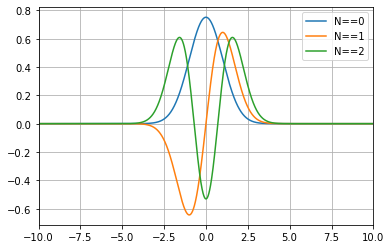

In [17]:

plt.plot(x.detach(), y_0.detach(), label="N==0")
plt.plot(x.detach(), y_1.detach(), label="N==1")
plt.plot(x.detach(), y_2.detach(), label="N==2")

plt.xlim([-10,10])

plt.legend()

plt.grid(True)
plt.show()

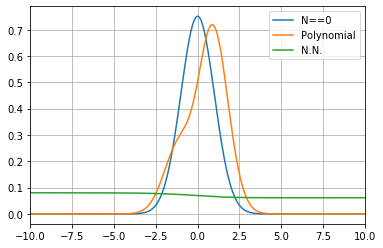

In [18]:
plt.plot(x.detach(), y_0.detach(), label="N==0")
plt.plot(x.detach(), y_poly.detach(), label="Polynomial")
plt.plot(x.detach(), y_nn.detach(), label="N.N.")

plt.xlim([-10,10])

plt.legend()

plt.grid(True)
plt.show()

## Plotting Probability distributions

We can also plot initial probability distributions:

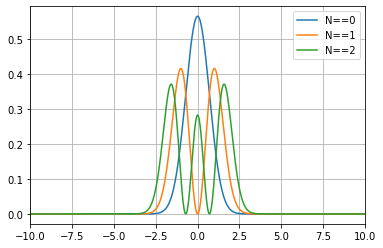

In [19]:
plt.plot(x.detach(), (y_0**2).detach(), label="N==0")
plt.plot(x.detach(), (y_1**2).detach(), label="N==1")
plt.plot(x.detach(), (y_2**2).detach(), label="N==2")

plt.xlim([-10,10])

plt.legend()

plt.grid(True)
plt.show()

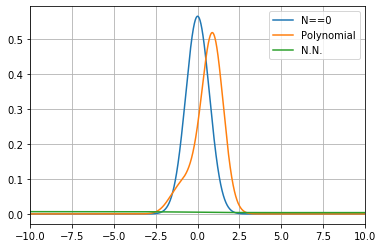

In [20]:
plt.plot(x.detach(), (y_0**2).detach(), label="N==0")
plt.plot(x.detach(), (y_poly**2).detach(), label="Polynomial")
plt.plot(x.detach(), (y_nn**2).detach(), label="N.N.")

plt.xlim([-10,10])

plt.legend()

plt.grid(True)
plt.show()

## Computing the energy of a wave function

To compute the energy, we need to know the derivative of the wave function with respect to x, the input.

For the exact solutions, we can know we have things correct since the energy is known.

For the polynomial wavefunction, we have an analytical derivative.  Let's check the analytical derivative first:

In [21]:
y_poly = w_poly(x)

In [22]:
# We should be able to get d \psi / dx with this:
if x.grad is not None:
    x.grad.zero_()
torch.sum(y_poly).backward(retain_graph=True)

Torch's autodifferentiation requires a scalar value.  I sum over all outputs since that introduces a chain rule of $1$ for every element, and doesn't distort the derivative.  Now we can compare:

In [23]:
print(torch.max(x.grad - w_poly.analytic_derivative(x)))

tensor(1.7881e-07, grad_fn=<MaxBackward1>)


As desired, it matches well.  The largest difference is $10^{-7}$

Now that we have the derivative, we can look at computing the energy.  We need three terms: kinetic energy, potential energy, and normalization.

In [24]:
def normalization(wavefunction, inputs, delta):
    return torch.sum(wavefunction(inputs) ** 2) * delta

In [25]:
print("Normalization of w_0: ", normalization(w_0, x, delta))
print("Normalization of w_1: ", normalization(w_1, x, delta))
print("Normalization of w_2: ", normalization(w_2, x, delta))
print("Normalization of w_poly: ", normalization(w_poly, x, delta))
print("Normalization of w_nn: ", normalization(w_nn, x, delta))

Normalization of w_0:  tensor(0.9930, grad_fn=<MulBackward0>)
Normalization of w_1:  tensor(0.9930, grad_fn=<MulBackward0>)
Normalization of w_2:  tensor(0.9930, grad_fn=<MulBackward0>)
Normalization of w_poly:  tensor(0.9930, grad_fn=<MulBackward0>)
Normalization of w_nn:  tensor(0.9930, grad_fn=<MulBackward0>)


As desired, all of the normalizations are coming out close to 1.

Now we can compute the other terms in the hamiltonian:

In [26]:
def potential_energy(wavefunction, inputs, delta):
    temp = 0.5*(M * omega **2) * wavefunction(inputs)**2 * inputs**2
    return torch.sum(temp) * delta

In [27]:
print("PE of w_0: ", potential_energy(w_0, x, delta))
print("PE of w_1: ", potential_energy(w_1, x, delta))
print("PE of w_2: ", potential_energy(w_2, x, delta))
print("PE of w_poly: ", potential_energy(w_poly, x, delta))
print("PE of w_nn: ", potential_energy(w_nn, x, delta))

PE of w_0:  tensor(0.2482, grad_fn=<MulBackward0>)
PE of w_1:  tensor(0.7447, grad_fn=<MulBackward0>)
PE of w_2:  tensor(1.2412, grad_fn=<MulBackward0>)
PE of w_poly:  tensor(0.5958, grad_fn=<MulBackward0>)
PE of w_nn:  tensor(1658.1676, grad_fn=<MulBackward0>)


In [28]:
def kinetic_energy(wavefunction, inputs, delta):
    if inputs.grad is not None:
        inputs.grad.zero_()
    scalar = torch.sum(wavefunction(inputs))
    scalar.backward(retain_graph=True)
    wavefunction_prime = x.grad
    return (hbar**2 / (2 *M)) * torch.sum(wavefunction_prime**2) * delta

In [29]:
print("KE of w_0: ", kinetic_energy(w_0, x, delta))
print("KE of w_1: ", kinetic_energy(w_1, x, delta))
print("KE of w_2: ", kinetic_energy(w_2, x, delta))
print("KE of w_poly: ", kinetic_energy(w_poly, x, delta))
print("KE of w_nn: ", kinetic_energy(w_nn, x, delta))

KE of w_0:  tensor(0.2482)
KE of w_1:  tensor(0.7447)
KE of w_2:  tensor(1.2412)
KE of w_poly:  tensor(0.1986)
KE of w_nn:  tensor(2.6148e-05)


Therefore, the computed energy for this wavefunction is:

In [30]:
def energy_calculation(wavefunction, inputs, delta):
    norm = normalization(wavefunction, inputs, delta)
    pe = potential_energy(wavefunction, inputs, delta)
    ke = kinetic_energy(wavefunction, inputs, delta)
    energy = (1/norm) * ( pe +  ke)
    return energy

In [31]:
print("Energy of w_0: ", energy_calculation(w_0, x, delta))
print("Energy of w_1: ", energy_calculation(w_1, x, delta))
print("Energy of w_2: ", energy_calculation(w_2, x, delta))
print("Energy of w_poly: ", energy_calculation(w_poly, x, delta))
print("Energy of w_nn: ", energy_calculation(w_nn, x, delta))

Energy of w_0:  tensor(0.5000, grad_fn=<MulBackward0>)
Energy of w_1:  tensor(1.5000, grad_fn=<MulBackward0>)
Energy of w_2:  tensor(2.5000, grad_fn=<MulBackward0>)
Energy of w_poly:  tensor(0.8000, grad_fn=<MulBackward0>)
Energy of w_nn:  tensor(1669.9153, grad_fn=<MulBackward0>)


The harmonic oscillator has energy levels of:
$$ E_n = \hbar \omega ( n + \frac{1}{2} ) $$
and so the ground state is $\hbar \omega / 2$. For this example, with $\hbar = 1$ and $\omega = 1$, we expect the estimate of the energy to be greater than or equal to 1/2.  The exact solutions are coming out exactly right.  Looks good above!

## Optimizing the wave function to find the ground state

In the above, we used the autograd functionality to compute the expectation value of energy of a wavefunction for the harmonic oscillator.  But, now we will use autograd again to compute the derivative of the energy with respect to the wavefunction's parameters, and optimize the parameters to update the wave function.

I re-wrote the energy computations to be more efficient.  I also introduced re-normalization of the wave function after every update.

In [32]:
def energy_computation(wavefunction, inputs, delta):
    
    # This function takes the inputs (assumed to be a range of real value parameters)
    # And computes the expectation value of the energy.
    
    # This is the value of the wave function:
    w_of_x = wavefunction(inputs)
    
    # Sum the wavefunction and call backwards to get the derivative of it with respect to x:
    grad_catalyst = torch.sum(w_of_x)
    grad_catalyst.backward(retain_graph = True)
    
    # This is the first derivative of the wave function:
    w_prime_dx = inputs.grad
    
    # Now we can compute integrals:
    normalization = torch.sum(w_of_x**2) * delta
    
    pe = (0.5 * M * omega**2 ) * torch.sum(w_of_x**2 * inputs**2) * delta
    
    ke = (hbar**2 / (2 *M)) * torch.sum(w_prime_dx**2) * delta
    
#     print()
#     print("pe: ", pe)
#     print("ke: ", ke)
#     print("norm: ", normalization)
#     print()

    
    energy = (pe + ke) / normalization
    
    return energy

In [33]:
def training_step(wavefunction, optimizer, delta):
    # Clear all gradients from the optimizer:
    optimizer.zero_grad()
    
    # Create fresh input data:
    _x = numpy.arange(-10, 10, delta, dtype=numpy.float32)
    _x = _x.reshape((_x.shape[0], 1))

    x = torch.autograd.Variable(torch.tensor(_x), requires_grad = True)

    # Compute the energy:
    energy = energy_computation(wavefunction, x, delta)

    # We back-prop'd through the wave function once already in the energy computation.  Clear the gradients:
    wavefunction.zero_grad()
    
    energy.backward(retain_graph=True)

    optimizer.step()
    
    # Lastly, update the normaliztion 
    wavefunction.update_normalization(x)

    return  energy



Let's train the polynomial wave function for awhile and see if it converges:

In [34]:
w_poly = PolynomialWavefunction()
delta = 0.0001

optimizer = torch.optim.Adam(w_poly.parameters(),lr=0.0001, weight_decay=1e-3)

energy_history = []
step_history = []

for i in range(5000):
    energy = training_step(w_poly, optimizer, delta)
    if i % 100 == 0: print(energy)
    
    energy_history.append(energy.detach().numpy())
    step_history.append(i)




    
    

tensor(0.8000, grad_fn=<DivBackward0>)
tensor(0.7722, grad_fn=<DivBackward0>)
tensor(0.7480, grad_fn=<DivBackward0>)
tensor(0.7265, grad_fn=<DivBackward0>)
tensor(0.7070, grad_fn=<DivBackward0>)
tensor(0.6887, grad_fn=<DivBackward0>)
tensor(0.6705, grad_fn=<DivBackward0>)
tensor(0.6514, grad_fn=<DivBackward0>)
tensor(0.6309, grad_fn=<DivBackward0>)
tensor(0.6097, grad_fn=<DivBackward0>)
tensor(0.5893, grad_fn=<DivBackward0>)
tensor(0.5714, grad_fn=<DivBackward0>)
tensor(0.5563, grad_fn=<DivBackward0>)
tensor(0.5442, grad_fn=<DivBackward0>)
tensor(0.5347, grad_fn=<DivBackward0>)
tensor(0.5275, grad_fn=<DivBackward0>)
tensor(0.5222, grad_fn=<DivBackward0>)
tensor(0.5185, grad_fn=<DivBackward0>)
tensor(0.5161, grad_fn=<DivBackward0>)
tensor(0.5147, grad_fn=<DivBackward0>)
tensor(0.5140, grad_fn=<DivBackward0>)
tensor(0.5139, grad_fn=<DivBackward0>)
tensor(0.5143, grad_fn=<DivBackward0>)
tensor(0.5150, grad_fn=<DivBackward0>)
tensor(0.5159, grad_fn=<DivBackward0>)
tensor(0.5170, grad_fn=<D

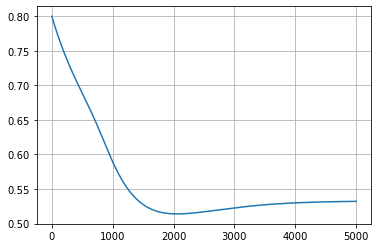

In [35]:
plt.plot(step_history, energy_history)
plt.grid(True)
plt.show()

As of now, it is strange: The energy decreased rapidly then bounced into a higher level and seems to have stabilized.

Now let's compare the fitted wave function with the REAL wavefunction for the ground state:

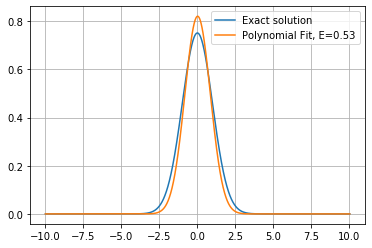

In [36]:

# Create fresh input data:
_x = numpy.arange(-10, 10, delta, dtype=numpy.float32)
_x = _x.reshape((_x.shape[0], 1))

x = torch.autograd.Variable(torch.tensor(_x), requires_grad = True)

y_exact = w_0(x)
y_fit   = w_poly(x)

x_numpy = x.detach().numpy()

energy_poly = energy_computation(w_poly, x, delta)

plt.plot(x_numpy, y_exact.detach().numpy(), label="Exact solution")
plt.plot(x_numpy, y_fit.detach().numpy(), label=f"Polynomial Fit, E={energy:.2}")
plt.grid(True)
plt.legend()
plt.show()

For completeness, we should also plot the probability distribution:

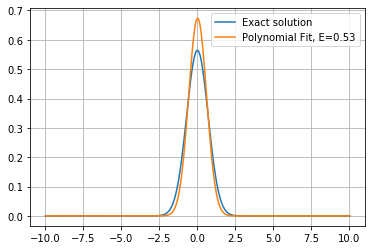

In [37]:

# Create fresh input data:
_x = numpy.arange(-10, 10, delta, dtype=numpy.float32)
_x = _x.reshape((_x.shape[0], 1))

x = torch.autograd.Variable(torch.tensor(_x), requires_grad = True)

p_exact = w_0(x)**2
p_fit   = w_poly(x)**2

x_numpy = x.detach().numpy()

energy_poly = energy_computation(w_poly, x, delta)

plt.plot(x_numpy, p_exact.detach().numpy(), label="Exact solution")
plt.plot(x_numpy, p_fit.detach().numpy(), label=f"Polynomial Fit, E={energy:.2}")
plt.grid(True)
plt.legend()
plt.show()

Here are the parameters of the network:

In [38]:

print("const term fit: ", w_poly.const.data)
print("linear term fit: ", w_poly.linear.data)
print("quad term fit: ", w_poly.quad.data)
print("norm term fit: ", w_poly.norm.data)



const term fit:  tensor(0.7621)
linear term fit:  tensor(0.0170)
quad term fit:  tensor(-0.0326)
norm term fit:  tensor([1.0767])


In a perfect fit, we expect the linear and quadratic terms to go to 0.0 and the constant term to stay != 0.  The absolute normalization is not of much importance.

Here, we do the same process for the neural network wave function:

In [39]:
w_nn = NeuralWavefunction()
delta = 0.001

optimizer = torch.optim.Adam(w_nn.parameters(),lr=0.001, weight_decay=1e-3)

energy_history = []
step_history = []

for i in range(5000):
    energy = training_step(w_nn, optimizer, delta)
    if i % 100 == 0: print(energy)
    
    energy_history.append(energy.detach().numpy())
    step_history.append(i)







tensor(17.3775, grad_fn=<DivBackward0>)
tensor(1.5330, grad_fn=<DivBackward0>)
tensor(1.1555, grad_fn=<DivBackward0>)
tensor(1.3213, grad_fn=<DivBackward0>)
tensor(1.0387, grad_fn=<DivBackward0>)
tensor(0.8954, grad_fn=<DivBackward0>)
tensor(0.7864, grad_fn=<DivBackward0>)
tensor(0.7117, grad_fn=<DivBackward0>)
tensor(0.6655, grad_fn=<DivBackward0>)
tensor(0.6366, grad_fn=<DivBackward0>)
tensor(0.6159, grad_fn=<DivBackward0>)
tensor(0.5992, grad_fn=<DivBackward0>)
tensor(0.5850, grad_fn=<DivBackward0>)
tensor(0.5727, grad_fn=<DivBackward0>)
tensor(0.5621, grad_fn=<DivBackward0>)
tensor(0.5529, grad_fn=<DivBackward0>)
tensor(0.5450, grad_fn=<DivBackward0>)
tensor(0.5382, grad_fn=<DivBackward0>)
tensor(0.5323, grad_fn=<DivBackward0>)
tensor(0.5274, grad_fn=<DivBackward0>)
tensor(0.5232, grad_fn=<DivBackward0>)
tensor(0.5197, grad_fn=<DivBackward0>)
tensor(0.5167, grad_fn=<DivBackward0>)
tensor(0.5141, grad_fn=<DivBackward0>)
tensor(0.5120, grad_fn=<DivBackward0>)
tensor(0.5102, grad_fn=<

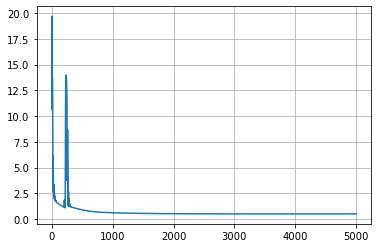

In [40]:
plt.plot(step_history, energy_history)
plt.grid(True)
plt.show()

As before, let's compare the exact and learned wavefunctions:

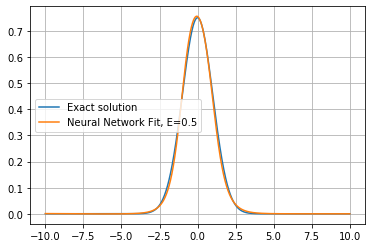

In [41]:

# Create fresh input data:
_x = numpy.arange(-10, 10, delta, dtype=numpy.float32)
_x = _x.reshape((_x.shape[0], 1))

x = torch.autograd.Variable(torch.tensor(_x), requires_grad = True)

y_exact = w_0(x)
y_fit   = w_nn(x)

x_numpy = x.detach().numpy()

energy_poly = energy_computation(w_poly, x, delta)

plt.plot(x_numpy, y_exact.detach().numpy(), label="Exact solution")
plt.plot(x_numpy, y_fit.detach().numpy(), label=f"Neural Network Fit, E={energy:.2}")
plt.grid(True)
plt.legend()
plt.show()

And the energy:

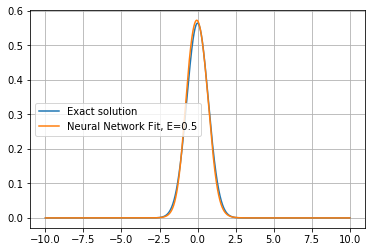

In [42]:

# Create fresh input data:
_x = numpy.arange(-10, 10, delta, dtype=numpy.float32)
_x = _x.reshape((_x.shape[0], 1))

x = torch.autograd.Variable(torch.tensor(_x), requires_grad = True)

p_exact = w_0(x)**2
p_fit   = w_nn(x)**2

x_numpy = x.detach().numpy()

energy_poly = energy_computation(w_poly, x, delta)

plt.plot(x_numpy, p_exact.detach().numpy(), label="Exact solution")
plt.plot(x_numpy, p_fit.detach().numpy(), label=f"Neural Network Fit, E={energy:.2}")
plt.grid(True)
plt.legend()
plt.show()

## Higher level states

Can we use ML techniques to learn higher level states?  The next wave function needs to be orthogonal to the ground state, so if our approximation is good, we should be able to minimize the energy and the orthogonal-ness of the first excited state at the same time.

In [45]:
def training_step_excited_state(wavefunction, known_wavefunction, optimizer, delta, alpha=5):
    # Clear all gradients from the optimizer:
    optimizer.zero_grad()
    
    # Create fresh input data:
    _x = numpy.arange(-10, 10, delta, dtype=numpy.float32)
    _x = _x.reshape((_x.shape[0], 1))

    x = torch.autograd.Variable(torch.tensor(_x), requires_grad = True)

    # Compute the energy:
    energy = energy_computation(wavefunction, x, delta)

    # Now, we have the energy.  We should make sure it is orthogonal to the known wavefunction:
    y1 = wavefunction(x)
    y0 = known_wavefunction(x)
    ortho = torch.sum(y0 * y1) * delta
    
    energy += alpha*ortho**2
    
    # We back-prop'd through the wave function once already in the energy computation.  Clear the gradients:
    wavefunction.zero_grad()
    
    energy.backward(retain_graph=True)

    optimizer.step()
    
    # Lastly, update the normaliztion 
    wavefunction.update_normalization(x)

    return  energy - alpha*ortho, ortho




In [46]:
w_nn_excited = NeuralWavefunction()
delta = 0.001

optimizer = torch.optim.Adam(w_nn_excited.parameters(),lr=0.001, weight_decay=1e-3)

energy_history = []
ortho_history = []
step_history = []

for i in range(5000):
    energy, ortho = training_step_excited_state(w_nn_excited, w_nn, optimizer, delta)
    if i % 100 == 0:
        print(f"Step {i}, E =={energy.data}, Orthogonality={ortho.data}")
    
    energy_history.append(energy.detach().numpy())
    ortho_history.append(energy.detach().numpy())
    step_history.append(i)





Step 0, E ==17.90654945373535, Orthogonality=0.14177972078323364
Step 100, E ==19.371417999267578, Orthogonality=-0.42262598872184753
Step 200, E ==9.350375175476074, Orthogonality=-0.7703830003738403
Step 300, E ==12.022425651550293, Orthogonality=-0.7678571343421936
Step 400, E ==18.953968048095703, Orthogonality=-0.44033539295196533
Step 500, E ==11.952428817749023, Orthogonality=-0.7936426997184753
Step 600, E ==10.387229919433594, Orthogonality=-0.7821113467216492
Step 700, E ==8.773139953613281, Orthogonality=-0.7480602264404297
Step 800, E ==9.334588050842285, Orthogonality=-0.6927585005760193
Step 900, E ==14.334228515625, Orthogonality=-0.6086705327033997
Step 1000, E ==15.46530532836914, Orthogonality=-0.11477971076965332
Step 1100, E ==6.918178558349609, Orthogonality=-0.4199848473072052
Step 1200, E ==3.4061012268066406, Orthogonality=-0.11350009590387344
Step 1300, E ==2.6905882358551025, Orthogonality=-0.05280487984418869
Step 1400, E ==2.4459750652313232, Orthogonality=-

##### 

In principle, this *ought* to come out somewhere near the first excited state.  Let's take a look at the wavefunctions:

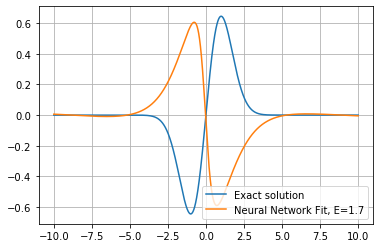

In [47]:

# Create fresh input data:
_x = numpy.arange(-10, 10, delta, dtype=numpy.float32)
_x = _x.reshape((_x.shape[0], 1))

x = torch.autograd.Variable(torch.tensor(_x), requires_grad = True)

y_exact = w_1(x)
y_fit   = w_nn_excited(x)

x_numpy = x.detach().numpy()

energy_poly = energy_computation(w_poly, x, delta)

plt.plot(x_numpy, y_exact.detach().numpy(), label="Exact solution")
plt.plot(x_numpy, y_fit.detach().numpy(), label=f"Neural Network Fit, E={energy:.2}")
plt.grid(True)
plt.legend()
plt.show()


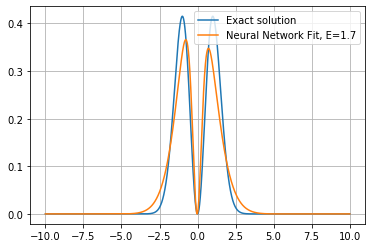

In [48]:

# Create fresh input data:
_x = numpy.arange(-10, 10, delta, dtype=numpy.float32)
_x = _x.reshape((_x.shape[0], 1))

x = torch.autograd.Variable(torch.tensor(_x), requires_grad = True)

p_exact = w_1(x)**2
p_fit   = w_nn_excited(x)**2

x_numpy = x.detach().numpy()

energy_poly = energy_computation(w_poly, x, delta)

plt.plot(x_numpy, p_exact.detach().numpy(), label="Exact solution")
plt.plot(x_numpy, p_fit.detach().numpy(), label=f"Neural Network Fit, E={energy:.2}")
plt.grid(True)
plt.legend()
plt.show()

All in all, this is not a terrible solution to the second excited state.  Likely more sophisticate optimization tricks can make this better.